<a href="https://colab.research.google.com/github/matthew-liu-zhenjie/GitWork_Sandbox/blob/main/A0230317U_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS3244 Assignment 1

We have seen the mathematical derivation of linear regression in class. In this problem, we shall convert that abstract understanding into implementation. You are encouraged to read this [introduction to linear algebra using PyTorch](https://d2l.ai/chapter_preliminaries/linear-algebra.html) before attempting if you have no prior experience with PyTorch.

In [ ]:
import matplotlib.pyplot as plt
import requests
import torch

In [ ]:
test_seed = 0

class TestCaseError(Exception):
    pass

def test_allclose(input, other):
    if input.shape != other.shape:
        raise TestCaseError("Wrong dimension")
    if not torch.allclose(input, other, atol=0.0002):
        raise TestCaseError("Wrong solution")
    return True

### Problem 0

Let us start with some administrative matters. Follow the instruction [here](https://docs.google.com/document/d/1-D06Tb-ylRNM5ja6iAuB5kxOGDybJOVLZvqEvzczH4Y/edit?usp=sharing) to set up your notebook .

From a probablistic perspective, we assume that there are some true weights $w_*$ that governs the relationship between inputs $X$ and targets $t$. In particular, $t\sim\mathcal{N}(w_*^\top x, \sigma^2)$. The `generate_1d_linear_data` function implements this sampling process. Specifically, it takes $w_*$ as `weights_true`, $m$ as `num_samples`, and outputs $X$ as `inputs` and $t$ as `targets`. Certainly, we are not going to have this generative process in practice, but it is useful to use such toy examples for enchancing our understanding of a topic. 

In [ ]:
def generate_1d_linear_data(weights_true, num_samples):
    uniform = torch.distributions.uniform.Uniform(0, 5)
    normal = torch.distributions.normal.Normal(0, 1)
    inputs, _ = torch.sort(uniform.sample([num_samples, 1]))
    augmented_inputs = torch.hstack((torch.ones(num_samples, 1), inputs))
    targets = augmented_inputs @ weights_true + normal.sample([num_samples])
    return inputs, targets

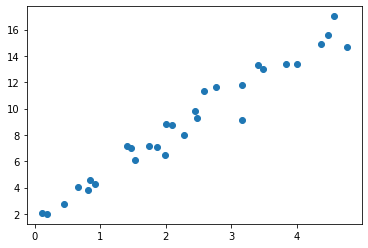

In [ ]:
torch.manual_seed(test_seed)
weights_true = torch.tensor([2., 3.])
inputs, targets = generate_1d_linear_data(weights_true, 30)

fig, ax = plt.subplots()
ax.scatter(inputs, targets)
fig.show()

Recall that the goal of linear regression is to find a $\hat{w}$ that best approximates the unknown $w_*$ using $X$ and $t$. As such, you should not use $w_*$ from here onwards.

### Problem 1

A common trick used to deal with the bias (or offset) term is to augment the input vector $x=[x_1,\dots,x_D]$ with $x_0=1$. This allows us to simplify the computation of

$$y(x)=w_0+\sum_{i=1}^D w_i x_i,$$

into a simple vector multiplication $y(x)=w^\top x$. Implement the `augment_linear_inputs` function with the following specifications:

**Input**

- `inputs`: the input matrix $X\in\mathbb{R}^{N\times D}$

**Output**

- the augmented input matrix where each row starts with 1

In [ ]:
def augment_linear_inputs(inputs):
    mtrx_shape = (inputs.size()[0],1)
    ones_matrx = torch.ones(mtrx_shape)
    augmented_inputs = torch.cat((ones_matrx, inputs), 1)
    return augmented_inputs

In [ ]:
# Public testcase for augment_linear_inputs

torch.manual_seed(test_seed)
weights_true = torch.tensor([2., 3.])
inputs, targets = generate_1d_linear_data(weights_true, 3)

augmented_inputs = augment_linear_inputs(inputs)
expected_augmented_inputs = torch.tensor([[1.0000, 2.4813], [1.0000, 3.8411], [1.0000, 0.4424]])
is_correct = test_allclose(augmented_inputs, expected_augmented_inputs)
print(f"Public testcase for augment_linear_inputs: {is_correct}")

Public testcase for augment_linear_inputs: True


### Problem 2

Implement the `error_gradient` function with the following specifications:

**Input**

- `weights_current`: the current weights $\hat{w}\in\mathbb{R}^{D+1}$ 
- `inputs`: the input matrix $X\in\mathbb{R}^{N\times(D+1)}$ 
- `targets`: the target vector $t\in\mathbb{R}^N$ 

**Output**

- the gradient of the error function $\nabla_w E(w)$

**Notes**

Note that the input is already augmented, hence the $D+1$ in dimension. On a separate note, you should write your code to work for arbitrary dimension $D$. This will be utilized from Problem 6 onwards. 

In [ ]:
def error_gradient(weights_current, inputs, targets):
    gradient = torch.matmul(torch.matmul(torch.t(inputs), inputs), weights_current) - torch.matmul(torch.t(inputs), targets)
    return gradient

In [ ]:
# Public testcase for error_gradient

torch.manual_seed(test_seed)
weights_true = torch.tensor([2., 3.])
inputs, targets = generate_1d_linear_data(weights_true, 3)
weights_current = torch.tensor([1., 1.])
augmented_inputs = augment_linear_inputs(inputs)

gradient = error_gradient(weights_current, augmented_inputs, targets)
expected_gradient = torch.tensor([-17.1925, -50.4709])
is_correct = test_allclose(gradient, expected_gradient)
print(f"Public testcase for error_gradient: {is_correct}")

Public testcase for error_gradient: True


### Problem 3

Implement the `gradient_descent` function with the following specificiations:

**Input**

- `weights_initial`: the initial guess for the weights $\hat{w}\in\mathbb{R}^{D+1}$ 
- `inputs`: the input matrix $X\in\mathbb{R}^{N\times(D+1)}$ 
- `targets`: the target vector $t\in\mathbb{R}^N$ 
- `learning_rate`: the learning rate $\alpha$
- `num_iterations`: the number of updates to the weights

**Output**

- the learned weights $\hat{w}$ after performing gradient descent on the data

In [ ]:
def gradient_descent(weights_initial, inputs, targets, learning_rate, num_iterations):
    weights_learned = weights_initial
    iterations = 0
    for i in range(0,num_iterations):
      error = error_gradient(weights_learned, inputs, targets)
      weights_learned -= learning_rate*error
    return weights_learned

In [ ]:
# Public testcase for gradient_descent

torch.manual_seed(test_seed)
weights_true = torch.tensor([2., 3.])
inputs, targets = generate_1d_linear_data(weights_true, 3)
augmented_inputs = augment_linear_inputs(inputs)
weights_initial = torch.tensor([1., 1.])
learning_rate = 0.001
num_iterations = 20

weights_learned = gradient_descent(weights_initial, augmented_inputs, targets, learning_rate, num_iterations)
expected_weights_learned = torch.tensor([1.2787, 1.8135])
is_correct = test_allclose(weights_learned, expected_weights_learned)
print(f"Public testcase for gradient_descent: {is_correct}")

Public testcase for gradient_descent: True


### Problem 4

Implement the `visualize_linear_model` function with the following specificiations. You are encouraged to read the [Basic Usage](https://matplotlib.org/stable/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py) and [Pyplot Tutorial](https://matplotlib.org/stable/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py) if you have no prior experience with Matplotlib. When plotting, adhere to the OO-style described in the [Coding Styles](https://matplotlib.org/stable/tutorials/introductory/usage.html#coding-styles) section.

**Input**

- `weights_current`: the weights vector $\hat{w}\in\mathbb{R}^2$ 
- `inputs`: the input matrix $X\in\mathbb{R}^{N\times 2}$ 
- `targets`: the target vector $t\in\mathbb{R}^N$ 

**Output**

- a `matplotlib` figure with
    - a <font color="red">red</font> scatter plot of `inputs` and `targets`
    - a <font color="green">green</font> line plot described by the `weights` vector

**Example**

If done right, your output should look like this (without the scribbles).

![index.png](https://drive.google.com/uc?export=view&id=1AajXyexn7yoy8GHZDX8z99356OhMSNC1)

**Notes**

This only works for $D=1$.

In [ ]:
def visualize_linear_model(weights_current, inputs, targets):
    fig, ax = plt.subplots()
    fresh_inputs = torch.flatten(torch.split(torch.t(inputs), 1)[1])
    ax.scatter(fresh_inputs, targets, color = 'green')
    ax.plot(fresh_inputs, torch.matmul(inputs, weights_current), color = 'red')
    ax.set_xlabel('x') 
    ax.set_ylabel('y')
    return fig

Let us see your code in action. The following code set the initial weights and hyperparameters, compute the learned weights using your `gradient_descent` function, and visualize the learned curve using your `visualize_model` function. If your curve fits the data and the `weights_learned` are close to $w_*=[2.0,3.0]$, you code is most likely correct.

Model weights are [1.7107689380645752, 3.080777406692505]


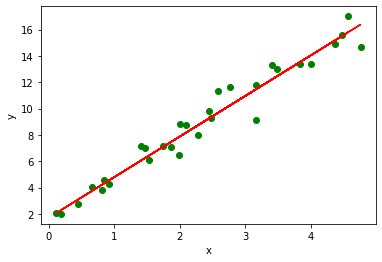

In [ ]:
# Public testcase for visualize_linear_model

torch.manual_seed(test_seed)
weights_true = torch.tensor([2., 3.])
inputs, targets = generate_1d_linear_data(weights_true, 30)
augmented_inputs = augment_linear_inputs(inputs)
weights_initial = torch.tensor([1., 1.])
learning_rate = 0.001
num_iterations = 20

weights_learned = gradient_descent(weights_initial, augmented_inputs, targets, learning_rate, num_iterations)
print(f"Model weights are {weights_learned.tolist()}")
fig = visualize_linear_model(weights_learned, augmented_inputs, targets)
fig.show()

### Problem 5

In the previous code block, we have arbitrarily set $\alpha=0.001$. Let us explore the effect of the learning rate in more detail. To do so, we want to visualize the error over the training process. Implement the `gradient_descent_with_logger` with the following specifications.

**Input**

- `weights_initial`: the initial guess for the weights $\hat{w}\in\mathbb{R}^{D+1}$ 
- `inputs`: the input matrix $X\in\mathbb{R}^{N\times(D+1)}$ 
- `targets`: the target vector $t\in\mathbb{R}^N$ 
- `learning_rate`: the learning rate $\alpha$
- `num_iterations`: the number of updates to the weights

**Output**

- the learned weights $\hat{w}$ after performing gradient descent on the data
- a PyTorch 1D-tensor of the error after each iteration of gradient descent (including the error before and after the training)

In [ ]:
def gradient_descent_with_logger(weights_initial, inputs, targets, learning_rate, num_iterations):
    weights_learned = weights_initial
    error_log = []
    iterations = 0
    for i in range(0,num_iterations):
      #error = torch.matmul(torch.matmul(torch.t(inputs), inputs), weights_learned) - torch.matmul(torch.t(inputs), targets)

      error = 0.5*torch.sum((weights_learned@(inputs.T) - targets)**2)
      
      error_log.append(error)
      weights_learned -= learning_rate*error_gradient(weights_learned, inputs, targets)
    error_log.append(0.5*torch.sum((inputs@(weights_learned.T) - targets)**2))
    errors = torch.tensor(error_log)
    return weights_learned, errors


In [ ]:
# Public testcase for gradient_descent_with_logger

torch.manual_seed(test_seed)
weights_true = torch.tensor([2., 3.])
inputs, targets = generate_1d_linear_data(weights_true, 30)
augmented_inputs = augment_linear_inputs(inputs)
weights_initial = torch.tensor([1., 1.])
learning_rate = 0.001
num_iterations = 5

_, error = gradient_descent_with_logger(weights_initial, augmented_inputs, targets, learning_rate, num_iterations)
expected_error = torch.tensor([597.8280, 349.5298, 206.3568, 123.8006, 76.1970, 48.7477])
is_correct = test_allclose(error, expected_error)
print(f"Public testcase for gradient_descent_with_logger: {is_correct}")

Public testcase for gradient_descent_with_logger: True


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  if sys.path[0] == '':


### Problem 6

To visualize the effect of the learning rate $\alpha$, we want to plot the error curve for multiple learning rates. Implement the `visualize_error` function with the following specificiations.

**Input**

- `weights_initial`: the initial guess for the weights $\hat{w}\in\mathbb{R}^2$ 
- `inputs`: the input matrix $X\in\mathbb{R}^{N\times 2}$ 
- `targets`: the target vector $t\in\mathbb{R}^N$ 
- `learning_rates`: an array of learning rates that we want to include in the visualization of the error curve
- `num_iterations`: the number of updates to the weights

**Output**

- a `matplotlib` figure with
    - a line plot for each error curve
    - a legend associating the learning rate to each error curve

**Example**

If done right, your output should look like this (without the scribbles).

![index.png](https://drive.google.com/uc?export=view&id=13Stf3A-77xOu6xreK-eQFuNS4W_yHfmm)

In [ ]:
def visualize_errors(weights_initial, inputs, targets, learning_rates, num_iterations):
    fig, ax = plt.subplots()
    results = []
    weights_list = []
    for i in range (0, len(learning_rates)):
      weights_list.append(torch.clone(weights_initial))
    for i in range(0,len(learning_rates)):
      rate = learning_rates[i]
      result = gradient_descent_with_logger(weights_list[i], inputs, targets, rate, num_iterations)
      results.append(result[1])
    for result in results:
      ax.plot(result)
      ax.legend(['0.0003',  '0.001', '0.003', '0.009'])
    return fig


Let us see your code in action again. The following code set the initial weights, provide a set of learning rates, and visualize the error curves for these learning rates. Can you give an explanation for your observation?

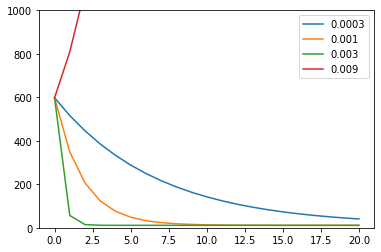

In [ ]:
# Public testcase for visualize_errors

torch.manual_seed(test_seed)
weights_true = torch.tensor([2., 3.])
inputs, targets = generate_1d_linear_data(weights_true, 30)
augmented_inputs = augment_linear_inputs(inputs)
weights_initial = torch.tensor([1., 1.])
learning_rates = [ 0.0003, 0.001, 0.003, 0.009 ]
num_iterations = 20

fig = visualize_errors(weights_initial, augmented_inputs, targets, learning_rates, num_iterations)
fig.axes[0].set_ylim([0, 1000])
fig.show()

Let us now shift our focus to fitting nonlinear functions. As mentioned prior to Problem 1,

> From a probablistic perspective, we assume that there are some true weights $w_*$ that governs the relationship between inputs $X$ and targets $t$. In particular, $t\sim\mathcal{N}(w_*^\top x, \sigma^2)$.

Instead of $y(x)=w_*^\top x$, let us assume that the underlying process $t(x)=a+bx+\ln(x^c)$ for some weight vector $w_*=[a,b,c]=[3,-2,5]$.

In [ ]:
def generate_1d_nonlinear_data(weights_true, num_samples):
    uniform = torch.distributions.uniform.Uniform(1, 5)
    normal = torch.distributions.normal.Normal(0, 0.1)
    inputs, _ = torch.sort(uniform.sample([num_samples, 1]), dim=0)
    targets = weights_true[0] * torch.ones([num_samples]) + \
              weights_true[1] * inputs[:,0] + \
              torch.log(inputs[:,0] ** weights_true[2]) + \
              normal.sample([num_samples])
    return inputs, targets

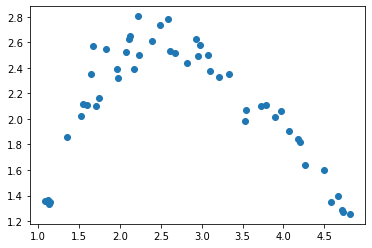

In [ ]:
torch.manual_seed(test_seed)
weights_true = torch.Tensor([3., -2., 5.])
inputs, targets = generate_1d_nonlinear_data(weights_true, 50)

fig, ax = plt.subplots()
ax.scatter(inputs, targets)
fig.show()

Also from Problem 1,

> Certainly, we are not going to have this generative process in practice, but it is useful to use such toy examples for enchancing our understanding of a topic. 

As usual, you should not use your knowledge of $w_*$ from here onwards. To fit this nonlinear curve, we need to use a basis function. Assuming we know the form, but not the exact parameters, of the underlying process, can you see why $\phi(x)=[1,x,\ln(x)]$ is a good choice of basis function?

### Problem 7

Implement the `basis_function` function with the following specifications.

**Input**

- `inputs`: the input matrix $X\in\mathbb{R}^{N\times 1}$

**Output**

- the mapped input $\phi(X)\in\mathbb{R}^{N\times 3}$ where each row is $\phi(x)=[1,x,\ln(x)]$

In [ ]:
def basis_function(inputs):
    mapped_inputs = torch.empty(len(inputs), 3)
    for i in range (0, len(inputs)):
      mapped_inputs[i][0] = 1
      mapped_inputs[i][1] = inputs[i]
      mapped_inputs[i][2] = torch.log(inputs[i])
    #print(mapped_inputs)
    return mapped_inputs


In [ ]:
# Public testcase for basis_function

torch.manual_seed(test_seed)
weights_true = torch.Tensor([3., -2., 5.])
inputs, targets = generate_1d_nonlinear_data(weights_true, 3)

mapped_inputs = basis_function(inputs.clone())
expected_mapped_inputs = torch.tensor([[1.0000, 1.3539, 0.3030], [1.0000, 2.9850, 1.0936], [1.0000, 4.0729, 1.4044]])
is_correct = test_allclose(mapped_inputs, expected_mapped_inputs)
print(f"Public testcase for basis_function: {is_correct}")

Public testcase for basis_function: True


### Problem 8

Implement the `visualize_nonlinear_model` function with the following specificiations.

**Input**

- `weights_current`: the weights vector $\hat{w}\in\mathbb{R}^3$ 
- `inputs`: the input matrix $X\in\mathbb{R}^{N\times 3}$ 
- `targets`: the target vector $t\in\mathbb{R}^N$ 

**Output**

- a `matplotlib` figure with
    - a <font color="red">red</font> scatter plot of `inputs` and `targets`
    - a <font color="green">green</font> line plot described by the `weights` vector

**Example**

If done right, your output should look like this (without the scribbles).

![index.png](https://drive.google.com/uc?export=view&id=12zoYCphS93pgAMNn5-zjV9atFcaUXvSp)

**Notes**

This only works for your choice of basis function.

In [ ]:
def visualize_nonlinear_model(weights_current, inputs, targets):
    fig, ax = plt.subplots()
    input_vals = []
    output_vals = []
    for i in inputs:
      input_vals.append(i[1])
      
    ax.scatter(input_vals, targets, color='red')
    ax.plot(input_vals, inputs@(weights_current.T), color='green')
    #ax.plot()
    #raise NotImplementedError()
    return fig

Let us put everything together. Note that if you implement `gradient_descent_with_logger` correctly, you should not need to make any modification on those functions here.

Model has an error of 12.644


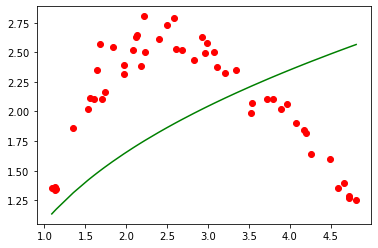

In [ ]:
# Public testcase for visualize_nonlinear_model

torch.manual_seed(test_seed)
weights_true = torch.Tensor([3., -2., 5.])
inputs, targets = generate_1d_nonlinear_data(weights_true, 50)
mapped_inputs = basis_function(inputs)
weights_initial = torch.Tensor([1., 1., 1.])
learning_rate = 0.001
num_iterations = 20

weights_learned, errors = gradient_descent_with_logger(weights_initial, mapped_inputs, targets, learning_rate, num_iterations)
print(f"Model has an error of {errors[-1]:.3f}")
fig = visualize_nonlinear_model(weights_learned, mapped_inputs, targets)
fig.show()

This looks really bad, and the error is really high. Perhaps looking at the error curve can help illuminate the issue.

In [ ]:
def plot_error_curve(errors):
    fig, ax = plt.subplots()
    ax.plot(errors)
    ax.set_ylim(0, 30)
    return fig

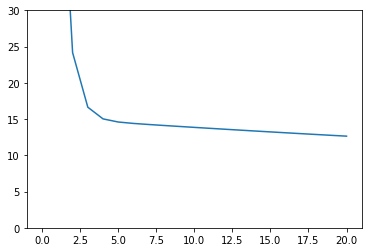

In [ ]:
fig = plot_error_curve(errors)
fig.show()

### Problem 9

It seems that the error is still decreasing slowly. Perhaps changing some hyperparamters might help. Change the hyperparameters in the `fit_nonlinear_model` function so that your model obtain an error of less than 0.6.

In [ ]:
def fit_nonlinear_model(inputs, targets):
    mapped_inputs = basis_function(inputs)
    weights_initial = torch.Tensor([1.0, 1.0, 1.0])
    ### start modifying the code here ###
    learning_rate = 0.003
    num_iterations = 2000
    ### stop modifying the code here ###
    weights_learned, errors = gradient_descent_with_logger(weights_initial, mapped_inputs, targets, learning_rate, num_iterations)
    fitted_figure = visualize_nonlinear_model(weights_learned, mapped_inputs, targets)
    return weights_learned, errors, fitted_figure

Model has an error of 0.398, which is less than the required error of 0.6.


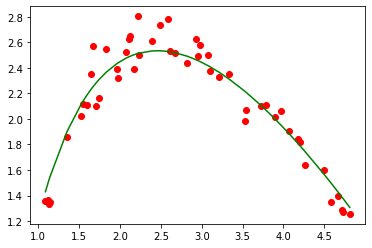

In [ ]:
# Public testcase for fit_nonlinear_model

torch.manual_seed(test_seed)
weights_learned, errors, fitted_figure = fit_nonlinear_model(inputs, targets)
error_relative_string = "more" if errors[-1] > 0.6 else "less"
print(f"Model has an error of {errors[-1]:.3f}, which is {error_relative_string} than the required error of 0.6.")
fitted_figure.show()

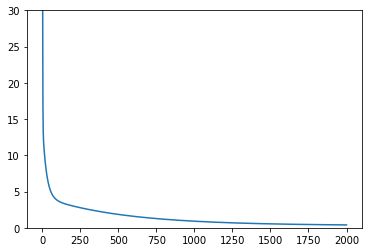

In [ ]:
error_figure = plot_error_curve(errors)
error_figure.show()